In [1]:
%matplotlib inline
import hast
import os
import fdulib as vdf
import emcee
from py_unsio import *
import numpy as np
from sklearn.neighbors import KDTree
from operator import add
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cfalcon
CF =cfalcon.CFalcon()
import pynbody

In [2]:
path ='/data/OWN/box_25Mpc_zoomed/output_00041'

In [3]:
def load_it(path):
    uns = CunsIn(path,"all","all",False)
    ok=uns.nextFrame("")
    if uns.isValid()!= True:
        print "NOT A VALID FILE"
        return
    p = vdf.info(path)
    ok,pos = uns.getArrayF("all","pos")
    ok,par_id = uns.getArrayI("all","id")
    shift =np.array([.5,.5,.5]*(len(pos)/3))
    ## center in halo and transform to kpc
    pos = np.array((pos-shift)*p.simutokpc,dtype=np.float32)
    pos3d = pos.reshape((len(pos)/3,3))
    condition = (mass<1e6)
    pos3d = pos3d[condition]
    par_id = par_id[condition]
    return pos3d, par_id

In [4]:
uns = CunsIn(path,"all","all",False)
ok=uns.nextFrame("")
print uns.isValid()

True


In [5]:

p = vdf.info(path)
          
ok,pos = uns.getArrayF("all","pos")
ok,par_id = uns.getArrayI("all","id")
ok,mass = uns.getArrayF("all","mass")

print len(mass), len(par_id)

4385585 4385585


In [6]:
mass =  np.array(mass * p.simutoMsun,dtype=np.float32)

shift =np.array([.5,.5,.5]*(len(pos)/3))

## center in halo and transform to kpc
pos = np.array((pos-shift)*p.simutokpc,dtype=np.float32)
pos3d = pos.reshape((len(pos)/3,3))
print np.max(mass), np.min(mass)

4.78136e+08 933860.0


In [7]:
x =pos[0::3]
y =pos[1::3]
z =pos[2::3]
r = np.sqrt((x**2)+(y**2)+(z**2))   

In [8]:
condition = (mass<1e6)
mass_zoom = mass[condition]
x_zoom=x[condition]
y_zoom=y[condition]
z_zoom=z[condition]
r_zoom=r[condition]
id_zoom=par_id[condition]
pos_zoom = pos3d[condition]
print len(x_zoom)
pos2 = np.zeros(3*len(mass_zoom))
pos2[0::3] =x_zoom
pos2[1::3] =y_zoom
pos2[2::3] =z_zoom
pos2 = np.array(pos2,dtype=np.float32)

1442456


In [9]:
print pos2


[-2062.69482422 -3904.66357422 -2505.1887207  ...,   124.85247803
  -644.47650146 -1269.88220215]


In [9]:
ok,rho_zoom,_=CF.getDensity(pos2, mass_zoom)

In [10]:
print len(pos_zoom)
av_center = [np.average(x_zoom)/p.simutokpc,
             np.average(y_zoom)/p.simutokpc,
             np.average(z_zoom)/p.simutokpc]
print av_center
av_centerkpc = [np.average(x_zoom),
                np.average(y_zoom),
                np.average(z_zoom)]

1442456
[-0.060667983174049755, -0.058557211054295392, -0.043349670787239891]


In [11]:
data=pynbody.load(path)
rbuffer=2.0*data.properties['a']/(data.properties['h']*data.properties['boxsize'])

In [12]:
def get_good_clumps(path_to_data,min_mass,max_mass):
        d=hast.halo_list(path,quiet=True)
        candidates,neighbors = hast.find_galaxy(d,rbuffer,min_mass,max_mass)
        clump_centers = np.array(d[candidates[0],4:7])-0.5
        clump_mass = np.array(d[candidates[0],10])
        clump_tree = KDTree(np.squeeze(clump_centers))
        zoom_clumps = clump_tree.query_radius(av_center,0.08)
        return clump_centers[zoom_clumps[0]]*(p.simutokpc),clump_mass[zoom_clumps[0]]
        

In [13]:
good_centers,good_mass = get_good_clumps(path,2e11,2e16)
good_centers910,good_mass910 = get_good_clumps(path,1e10,2e11)
good_centers79,good_mass79 = get_good_clumps(path,1e9,1e10)
try:
    mass_max = np.max(good_mass)
    center_max = (good_centers[np.where(good_mass==mass_max)]/p.simutokpc+(0.5))[0]
except:
    mass_max =0.
    center_max = [[0.,0.,0.]]
print "#########",len(good_centers), len(good_centers79), mass_max
print good_centers

| Building Tree with 6807 haloes
| Querying halo Tree
| Building Tree with 6807 haloes
| Querying halo Tree
| Building Tree with 6807 haloes
| Querying halo Tree
######### 1 224 410889988412.0
[[-1725.49522631 -1721.85505794 -1297.322697  ]]


In [14]:

#print len(dk)
#39 387101011970.0
#41 410889988412.0




In [15]:
#### virial radius
data = data[np.argsort(data['iord'])]
print center_max
try:
    rr = pynbody.analysis.halo.virial_radius(data,cen=center_max)#,r_max=0.5*rbuffer)
except:
    print '| [Warning] Virial radius computation did not converge'
    rr = 0.


[ 0.44157042  0.44169368  0.45606941]


In [16]:
print center_max
inside = good_centers79[(good_centers79[:,2]>(center_max[2]-.5)*p.simutokpc+.5)&(good_centers79[:,2]>(center_max[2]-.5)*p.simutokpc-.5)]
print len(inside), len(good_centers79)

[ 0.44157042  0.44169368  0.45606941]
116 224


In [17]:
print (center_max[0]-.5)*p.simutokpc

-1725.49522631


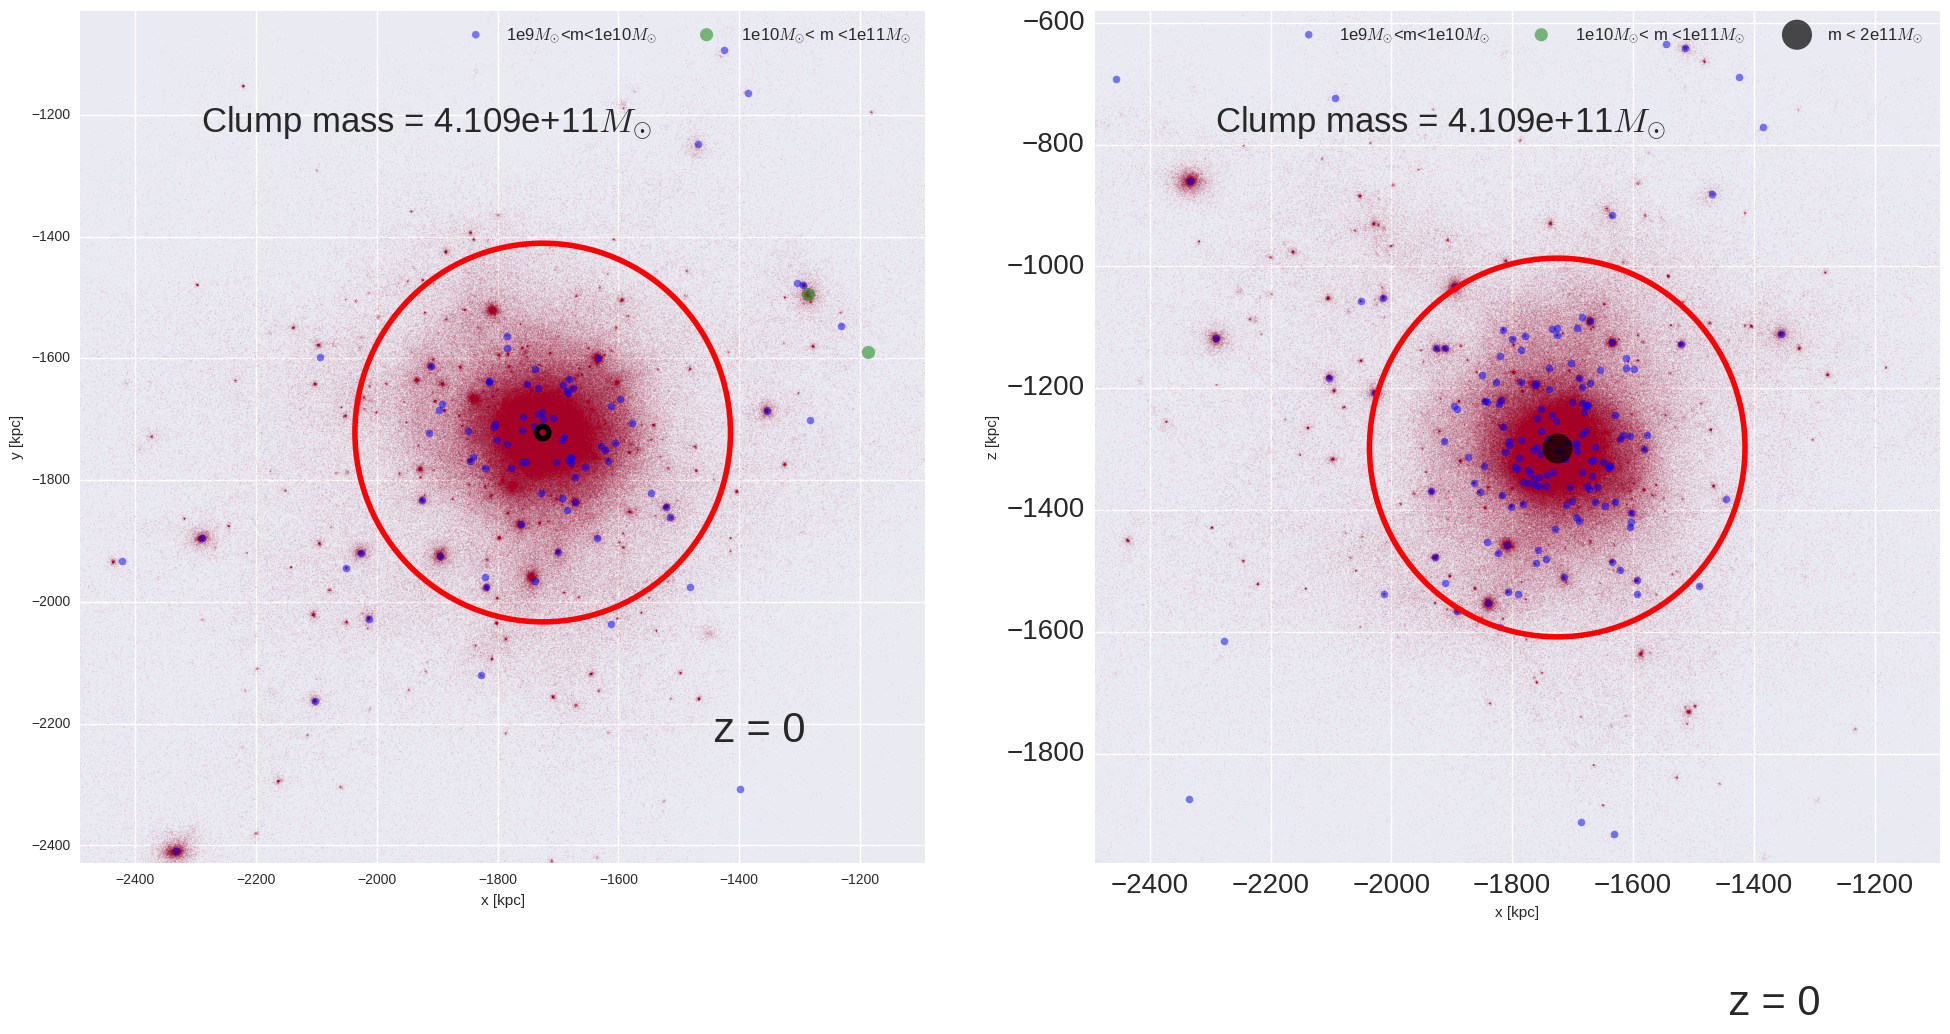

In [18]:
fig,[ax,ax1]=plt.subplots(1,2,figsize=[24,11])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

########### first plot
ax.set_xlabel("x [kpc]")
ax.set_ylabel("y [kpc]")
ax.set_ylim([av_centerkpc[1]-700,av_centerkpc[1]+700])
ax.set_xlim([av_centerkpc[0]-700,av_centerkpc[0]+700])
        

ax.text(av_centerkpc[0]+350,av_centerkpc[1]-500,'z = '+str(int(p.z)),fontsize=30)
    
if mass_max>0.0:
    ax.text(av_centerkpc[0]-500,av_centerkpc[1]+500,'Clump mass = {0:.3e}'.format(mass_max)+r'$M_{\odot}$',fontsize=25)
        
cm = plt.cm.get_cmap('RdYlBu')
sc =ax.scatter(x_zoom,y_zoom,c=rho_zoom,vmin=1e6, vmax=1e9,
               alpha=.1,marker='o',s=.5,cmap=cm,lw=0)

#====SmallClumps
sc =ax.scatter(inside[:,0],inside[:,1],c='b',
               alpha=.5,marker='o',s=30,lw=0,label=r'1e9$M_{\odot}$<m<1e10$M_{\odot}$')

#====MidleClumps
sc =ax.scatter(good_centers910[:,0],good_centers910[:,1],c='g',
               alpha=.5,marker='o',s=90,lw=0,
               label=r' 1e10$M_{\odot}$< m <1e11$M_{\odot}$')
#====BigClump
if mass_max > 0:
    circle1 = plt.Circle(((center_max[0]-.5)*p.simutokpc,
                           (center_max[1]-.5)*p.simutokpc),
                          rr*p.simutokpc, color='r',lw=4, fill=False)
    circle3 = plt.Circle(((center_max[0]-.5)*p.simutokpc,
                           (center_max[1]-.5)*p.simutokpc),
                          10, color='k',lw=4, fill=False)
    ax.add_patch( circle1 )
    ax.add_patch( circle3 )

    #sc =ax.scatter(good_centers[:,0],good_centers[:,1],c='k',
    #               alpha=.7,marker='o', lw=0, s=470*((mass_max/410889988412.0)**3),
    #               label=r'm < 2e11$M_{\odot}$')

legend = ax.legend(loc='upper right', ncol=3, shadow=False, fontsize=12)
frame = legend.get_frame()

########### second plot
ax1.set_xlabel("x [kpc]")
ax1.set_ylabel("z [kpc]")
ax1.set_ylim([av_centerkpc[2]-700,av_centerkpc[2]+700])
ax1.set_xlim([av_centerkpc[0]-700,av_centerkpc[0]+700])
        
ax1.text(av_centerkpc[0]+350,av_centerkpc[1]-500,'z = '+str(int(p.z)),fontsize=30)

if mass_max>0.0:
    ax1.text(av_centerkpc[0]-500,av_centerkpc[2]+500,'Clump mass = {0:.3e}'.format(mass_max)+r'$M_{\odot}$',fontsize=25)
        
cm = plt.cm.get_cmap('RdYlBu')
sc =ax1.scatter(x_zoom,z_zoom,c=rho_zoom,vmin=1e6, vmax=1e9,
               alpha=.1,marker='o',s=.5,cmap=cm,lw=0)
#====SmallClumps
sc =ax1.scatter(good_centers79[:,0],good_centers79[:,2],c='b',
               alpha=.5,marker='o',s=30,lw=0,label=r'1e9$M_{\odot}$<m<1e10$M_{\odot}$ ')

#====MidleClumps
sc =ax1.scatter(good_centers910[:,0],good_centers910[:,2],c='g',
               alpha=.5,marker='o',s=90,lw=0,
               label=r' 1e10$M_{\odot}$< m <1e11$M_{\odot}$ ')
#====BigClump
if mass_max > 0:
    circle2 = plt.Circle(((center_max[0]-.5)*p.simutokpc,
                           (center_max[2]-.5)*p.simutokpc),
                          rr*p.simutokpc, color='r',lw=4, fill=False)
    ax1.add_patch( circle2 )
    sc =ax1.scatter(good_centers[:,0],good_centers[:,2],c='k',
                   alpha=.7,marker='o', lw=0, s=470*((mass_max/410889988412.0)**3),
                   label=r'm < 2e11$M_{\odot}$ ')

legend = ax1.legend(loc='upper right', ncol=3, shadow=False, fontsize=12)
frame = legend.get_frame()

fig.savefig('temp.png')


In [19]:
par_tree = KDTree(pos3d)
in_10kpc =par_tree.query_radius(good_centers[0],10.)
cores = par_id[in_10kpc[0]]

In [57]:
#path = '/data/OWN/box_25Mpc_zoomed/output_00040'
def follow(path,cores,no_core=True):
    pos,ids = load_it(path)
    poscore = pos[(ids==cores)]
    poscore = pos[np.in1d(ids, cores)]
    center = [np.average(poscore[:,0]),np.average(poscore[:,1]),np.average(poscore[:,2])]
    pos_tmp = poscore-center
    r_tmp = np.sqrt(pos_tmp[:,0]**2 + pos_tmp[:,1]**2 + pos_tmp[:,2]**2)
    r_std = np.sqrt(np.std(pos_tmp[:,0])**2 + np.std(pos_tmp[:,1])**2 + np.std(pos_tmp[:,2])**2)
    if no_core:
        return center,r_std
    else:
        return center,r_std,poscore

In [51]:
files = os.listdir('/data/OWN/box_25Mpc_zoomed/')
centers, stds = np.array([]),np.array([])
simu = np.array([])
for fn in files:
    if fn[0:3]!='out':
        continue
    if int(fn[-2:])<6:
        continue
    print '############',fn
    simu = np.append(simu,int(fn[-2:]))
    path = '/data/OWN/box_25Mpc_zoomed/'+fn
    center, std = follow(path,cores)
    centers = np.append(centers,center)
    stds = np.append(stds,std)
    


############ output_00006
############ output_00016
############ output_00017
############ output_00013
############ output_00010
############ output_00041
############ output_00035
############ output_00023
############ output_00034
############ output_00007
############ output_00029
############ output_00039
############ output_00020
############ output_00037
############ output_00021
############ output_00018
############ output_00024
############ output_00008
############ output_00012
############ output_00033
############ output_00015
############ output_00027
############ output_00011
############ output_00031
############ output_00032
############ output_00025
############ output_00014
############ output_00026
############ output_00040
############ output_00019
############ output_00036
############ output_00028
############ output_00022
############ output_00009
############ output_00038
############ output_00030


In [52]:
centers3d = centers.reshape((len(centers)/3,3))


In [53]:
#print centers3d
#print stds[np.argsort(simu)]
#print simu[np.argsort(simu)]

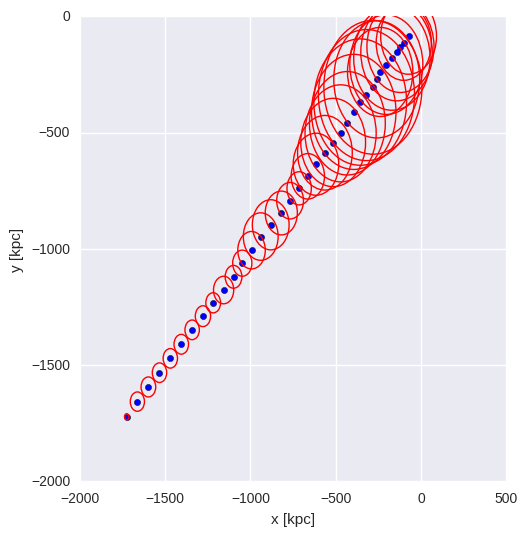

In [55]:
fig,ax = plt.subplots(figsize=[5.5,6])
ax.scatter(centers3d[:,0],centers3d[:,1])
i = 0
for i in range(0,len(stds)):
    circle = plt.Circle(((centers3d[i][0]),(centers3d[i][1])),
                          2*stds[i], color='r',lw=1, fill=False)
    ax.add_patch( circle )
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')

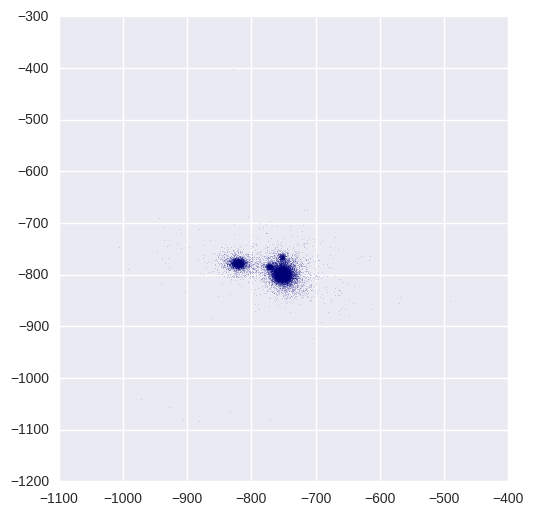

In [67]:
center, std, pars = follow('/data/OWN/box_25Mpc_zoomed/output_00025',cores, no_core=False)
fig, ax = plt.subplots(figsize=[5.8,6])
ax.scatter(pars[:,0],pars[:,1],alpha=.1,marker='o',s=.5,lw=0)

456.545454545 223.2
width  1296
583.2


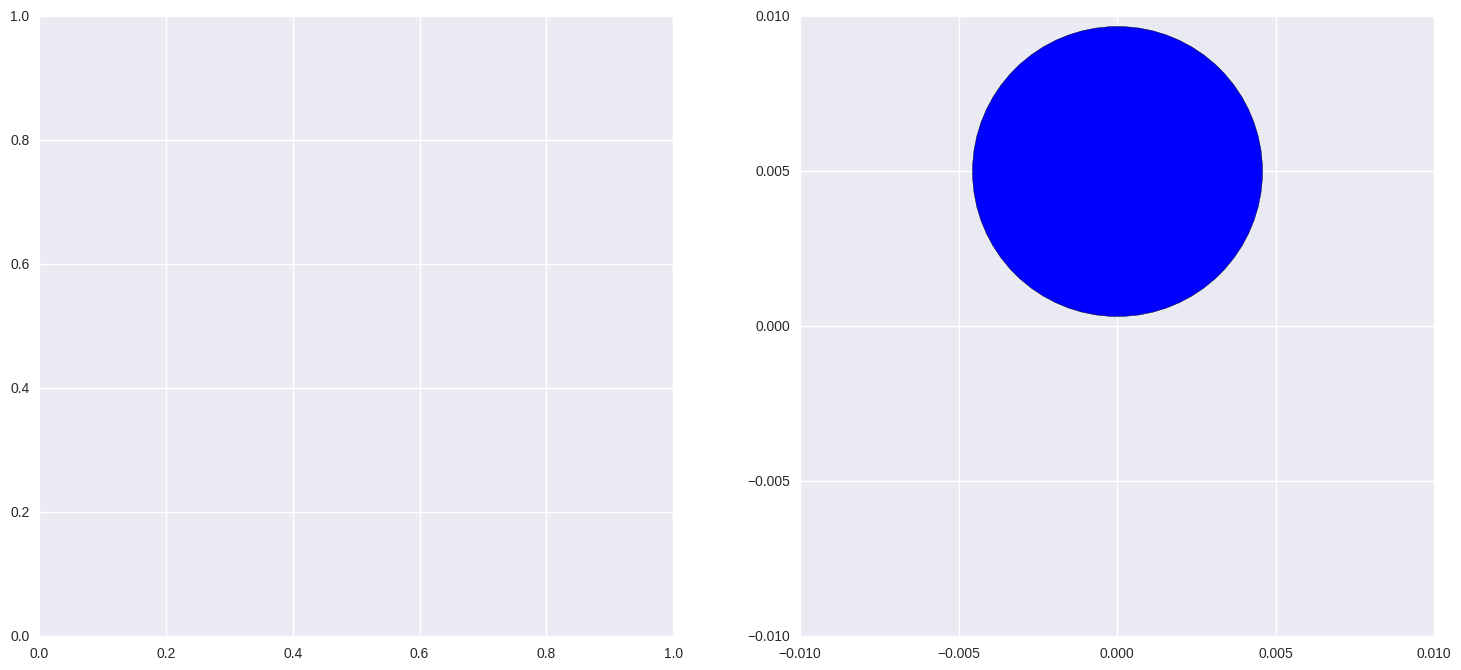

In [39]:
fig, ax = plt.subplots(1,2,figsize=(18,8))
ax[1].set_xlim([-0.01,0.01])
ax[1].set_ylim([-0.01,0.01])

xy_pixels = ax[1].transData.transform([0.01,0])
xpix, ypix = xy_pixels.T

xy_pixels = ax[1].transData.transform([-0.010,-0.010])
xpix2, ypix2 = xy_pixels.T
print abs(xpix-xpix2), abs(ypix-ypix2)

width, height = fig.canvas.get_width_height()
ypix = height - ypix

print "width ", width
su = xpix*0.005/0.01
print su
ax[1].scatter(0.,0.005, s=(ypix-ypix2)**2)

In [43]:
ara = [[1,1,1,1,1,1,1,1],[12,2,2,2,2,2,2,2]]
dproj =[[5,4],[6,4]]
print dproj[1][0]

print ara[:,:]

6


TypeError: list indices must be integers, not tuple